In [1]:
import numpy as np
from numba import jit
import time
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import math
from scipy.stats import norm
import random

## Part II: Estimation of Sensitivities in MC

In [2]:
def Delta_Analytical_Call(S, K, r, sigma, tau):
    d1 = (math.log(S/K) + (r + 0.5 * sigma**2) * tau) / (sigma * math.sqrt(tau))
    return norm.cdf(d1)

def Delta_Analytical_Digital(S, K, r, sigma, tau):
    d2 = (math.log(S/K) + (r-0.5*sigma**2)*tau) / (sigma * math.sqrt(tau))
    numerator = (math.e**(-r * tau)) * norm.pdf(d2) 
    denomenator = sigma * S * math.sqrt(tau)
    
    return numerator/denomenator

In [3]:
@jit(nopython=True, fastmath=True, parallel=False)
def European_Call(T, K, r, S, sigma, trials, z):
    '''
    This function calculates the value of an European Call option
    Arguments: maturity, strike price, interest rate, stock price, volaility, number of trials
    Returns: Array of size trial with values of european puts
    '''
    
    S_adjust = S * np.exp(r - (0.5 * sigma**2)*T)
    payoff_array = np.zeros(trials)

    for i in range(trials):
        S_cur = S_adjust * np.exp(sigma*np.sqrt(T)*z[i])
        
        if S_cur-K > 0:
            payoff_array[i] = (S_cur-K)*np.exp(-r*T)
        else:
            payoff_array[i] = 0

    return np.mean(payoff_array)


@jit(nopython=True, fastmath=True, parallel=False)
def Digital_Call(T, K, r, S, sigma, trials, z):
    
    S_adjust = S * np.exp(r - (0.5 * sigma**2)*T)
    payoff_array = np.zeros(trials)
    
    for i in range(trials):
        S_cur = S_adjust * np.exp(sigma*np.sqrt(T)*z[i])
        
        if S_cur > K:
            payoff_array[i] = 1 * math.e**(-r*T)
        else:
            payoff_array[i] = 0

    return np.mean(payoff_array)

In [4]:
def get_delta_call(kwargs, S, e, seed=None):
    z=np.zeros(kwargs['trials'])
    for i in range(kwargs['trials']):
        z[i] = np.random.normal()
        
    kwargs['z'] = z   
    kwargs['S'] = S
    
    V = European_Call(**kwargs)
    
    if not seed:
        for i in range(kwargs['trials']):
            z[i] = random.normalvariate(0, 1)
        kwargs['z'] = z   
        
    kwargs['S'] = S + e
    Ve = European_Call(**kwargs)
    
    return (Ve-V)/ e


def get_delta_digital(kwargs, S, e, seed=None):
    z=np.zeros(kwargs['trials'])
    for i in range(kwargs['trials']):
        z[i] = np.random.normal()
        
    kwargs['z'] = z   
    kwargs['S'] = S
    
    V = Digital_Call(**kwargs)
    
    if not seed:
        for i in range(kwargs['trials']):
            z[i] = random.normalvariate(0, 1)
        kwargs['z'] = z   
        
    kwargs['S'] = S + e
    
    Ve = Digital_Call(**kwargs)
    
    return (Ve-V)/ e

In [5]:
analytical = Delta_Analytical_Call(100, 99, 0.06, 0.2, 1)
analytical

0.6737355117348961

In [6]:
kwargs = {}
kwargs['T'] = 1
kwargs['K'] = 99
kwargs['r'] = 0.06
kwargs['sigma'] = 0.2
kwargs['trials'] = 10**4

In [8]:
S = 100
e = .02

delta_matrix_noseeds = [get_delta_call(kwargs, S, e, None) for x in range(100)]
delta_matrix_seeds = [get_delta_call(kwargs, S, e, 100) for x in range(100)]

In [9]:
# Relative error with analytical value as reference
rel_error_same_seed = abs(analytical - np.mean(delta_matrix_seeds)) / analytical * 100
print(f"Relative error based on same seed: {rel_error_same_seed}%")

Relative error based on same seed: 0.06276673983532459%


In [10]:
rel_error_random_seed = abs(analytical - np.mean(delta_matrix_noseeds)) / analytical * 100
print(f"Relative error based on random seed: {rel_error_random_seed}%")

Relative error based on random seed: 24.50862418751412%


In [11]:
eps = [0.01,0.02,0.5]
size = [4,5,6,7]

In [12]:
seeded = np.matrix(np.zeros(12))
seeded.shape = (4,3)

unseeded = np.matrix(np.zeros(12))
unseeded.shape = (4,3)

In [13]:
def get_convergence_matrix(analytical):
    for row in range(len(size)):
        for column in range(len(eps)):
            kwargs['trials'] = 10**size[row]
            e = eps[column]
            seeded[row,column] = abs(analytical - np.mean(get_delta_call(kwargs, S, e, 100))) / analytical * 100
            unseeded[row,column] = abs(analytical - np.mean(get_delta_call(kwargs, S, e,None))) / analytical * 100
            
    return seeded, unseeded

#### Matrices as in lecture Monte-Carlo II (slides 24 and 26)

In [14]:
results = Parallel(n_jobs = 12)(delayed(get_convergence_matrix)(analytical) for i in range(12))

In [15]:
seeded = []
unseeded = []
for result in results:
    seeded.append(result[0])
    unseeded.append(result[1])

In [16]:
all_unseeded = np.matrix(np.zeros(12))
all_unseeded.shape = (4,3)

all_seeded = np.matrix(np.zeros(12))
all_seeded.shape = (4,3)

for mat in unseeded:
    for row in range(mat.shape[0]):
        for column in range(mat.shape[1]):
            all_unseeded[row, column] += mat[row, column]
            
for mat in seeded:
    for row in range(mat.shape[0]):
        for column in range(mat.shape[1]):
            all_seeded[row, column] += mat[row, column]

In [17]:
all_unseeded/12

matrix([[2.42038627e+03, 1.32094192e+03, 5.53590805e+01],
        [6.21503298e+02, 4.43650979e+02, 1.60756598e+01],
        [2.76195613e+02, 1.21854152e+02, 5.62214481e+00],
        [7.13383926e+01, 4.62454715e+01, 1.68027459e+00]])

In [18]:
all_seeded/12

matrix([[0.85530799, 0.63174749, 0.72071688],
        [0.19706205, 0.19470396, 0.7316942 ],
        [0.06502715, 0.07764741, 0.64492627],
        [0.01981168, 0.02767675, 0.64577901]])

## Part 2.2

In [7]:
# Analytical digital
#https://448elmwood.files.wordpress.com/2015/04/study_pricing_digital_call_options1.pdf

analytical = Delta_Analytical_Digital(S=100, K=99, r=0.06, sigma=0.2, tau=1); analytical

0.018206369779490493

In [20]:
kwargs['trials'] = 10**4
S=100
e = 0.02
ans = [get_delta_digital(kwargs, S, e, 100) for x in range(100)]
np.mean(ans)

0.018270231951536264

In [21]:
digital = np.matrix(np.zeros(12))
digital.shape = (4,3)

eps = [0.01,0.02,0.5]
size = [4,5,6,7]

In [24]:
def digital_convergence_matrix(analytical):
    for row in range(len(size)):
        for column in range(len(eps)):
            kwargs['trials'] = 10**size[row]
            e = eps[column]
            digital[row,column] = abs(analytical - get_delta_digital(kwargs, S, e, 100)) / analytical * 100
    return digital

In [25]:
results = Parallel(n_jobs = 12)(delayed(digital_convergence_matrix)(analytical) for i in range(12))

In [26]:
all_digital = np.matrix(np.zeros(12))
all_digital.shape = (4,3)


for mat in results:
    for row in range(mat.shape[0]):
        for column in range(mat.shape[1]):
            all_digital[row, column] += mat[row, column]
all_digital = all_digital/12

In [27]:
all_digital

matrix([[47.41660014, 28.01890008,  9.45556941],
        [13.36286004, 20.2627802 ,  1.36403662],
        [ 5.15736463,  4.43991801,  0.95070736],
        [ 1.60300664,  1.04989938,  0.58342495]])

## Pathwise Method

In [40]:
np.arange(0,10, 1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

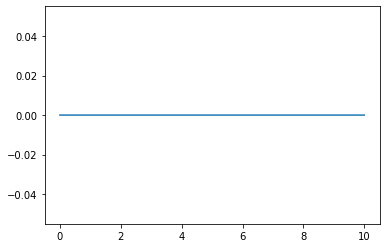

In [315]:
plt.plot( np.arange(0,10, 0.001), [norm.pdf(x, loc=1, scale=0.001) for x in np.arange(0,10, 0.001)])

In [177]:
def Digital_Call_Pathwise(T, K, r, S, sigma, trials, z):
    
    S_adjust = S * np.exp(r - (0.5 * sigma**2)*T)
    payoff_array = np.zeros(trials)
    
    for i in range(trials):
        S_cur = S_adjust * np.exp(sigma*np.sqrt(T)*z[i])
        
        payoff_array[i] = norm.cdf(S_cur, loc=K, scale=0.000001)

    return np.mean(payoff_array)


def get_delta_digital_pathwise(kwargs, S, e, seed=None):
    z=np.zeros(kwargs['trials'])
    for i in range(kwargs['trials']):
        z[i] = np.random.normal()
        
    kwargs['z'] = z   
    kwargs['S'] = S
    
    V = Digital_Call(**kwargs)
    
    if not seed:
        for i in range(kwargs['trials']):
            z[i] = random.normalvariate(0, 1)
        kwargs['z'] = z   
        
    kwargs['S'] = S + e
    
    Ve = Digital_Call_Pathwise(**kwargs)
    
    return (Ve-V)/ e

In [206]:
kwargs['trials'] = 10**4
S = 100
e = 10
#ans = [get_delta_digital_pathwise(kwargs, S, e, 100) for x in range(100)]
abs(analytical - np.mean(ans)) / analytical * 100

11.18475226897998

In [212]:
get_delta_digital_pathwise(kwargs, S, 15, 100)

0.017655952029017315

In [15]:
abs(analytical - np.mean(ans)) / analytical * 100

19141.87049686275

In [341]:
trials = 10000
r=0.06
sigma=0.2
T=1
K=99



S_adjust = S * np.exp(r - (0.5 * sigma**2)*T)
payoff_array = np.zeros(trials)
scurs= np.zeros(trials)
count=0

for i in range(trials):
    S_cur = S_adjust * np.exp(sigma*np.sqrt(T)*np.random.normal())
    scurs[i]=S_cur
    
    

    payoff_array[i] = math.e**(-r) * norm.pdf(x = S_cur, loc=K, scale=1) * S_cur/S


In [342]:
np.mean(payoff_array)

0.018412838679295912

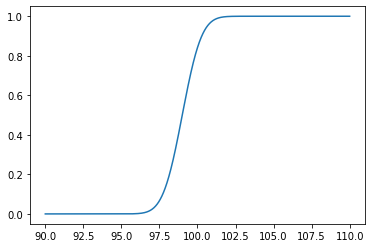

In [326]:
plt.plot( np.arange(90,110, 0.001), [norm.cdf(x, loc=K, scale=1) for x in np.arange(90,110, 0.001)])

In [300]:
    if S_cur-K>0 :
        payoff_array[i] = math.e**(-r) * norm.pdf(x = K, loc= S_cur, scale=5) * S_cur/S

    else:
        payoff_array[i] = 0

## Likelihood ratio Method for estimating delta in digital options

In [368]:
trials = 1000
r=0.06
sigma=0.2
T=1
K=99



S_adjust = S * np.exp(r - (0.5 * sigma**2)*T)
payoff_array = np.zeros(trials)
scurs= np.zeros(trials)
count=0

for i in range(trials):
    Z = np.random.normal()
    S_cur = S_adjust * np.exp(sigma*np.sqrt(T)*Z)
    
    if S_cur > K:
        payoff_array[i] = math.e**(-r) * Z/(sigma*S)
    else:
        payoff_array[i] = 0
        


In [369]:
np.mean(payoff_array)

0.018385226189605263